In [1]:
from matplotlib import pyplot as plt
import numpy as np
import fuzzylite as fl

from src.elegant_fuzzy_genetic_algorithms.helpers.param_inference import ParamInference
from src.elegant_fuzzy_genetic_algorithms.conf.param_inference_config import Conf

In [2]:
def plot_variable(var, universe=None):
    if universe is None:
        universe = (var.minimum, var.maximum)
    plt.title(var.name)
    linguistic_terms_names = []
    vals = np.linspace(*universe, 100)
    
        
    for term in var.terms:
        membership_fn = [term.membership(e) for e in vals]
        plt.plot(vals, membership_fn)
        linguistic_terms_names.append(term.name)
    plt.legend(linguistic_terms_names)
    plt.xlabel(var.name)
    plt.ylabel('membership function')
    plt.show()

In [3]:
priority_inferencer =  ParamInference(rule_path_param=Conf.rule_path_param, rule_path_priority=Conf.rule_path_priority)

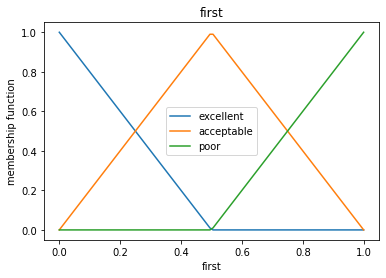

In [4]:
plot_variable(priority_inferencer.first_cl, universe=(0, 1))

In [5]:
first_cl = fl.InputVariable(
        name="first",
        description="",
        enabled=True,
        minimum=0.0,
        maximum=1.0,
        lock_range=False,
        terms=[
            fl.Trapezoid("excellent", -1, 0, 0, 0.5),
            fl.Triangle("acceptable", 0, 0.5, 1,),
            fl.Trapezoid("poor", .5, 1, 1, 2),
        ],)


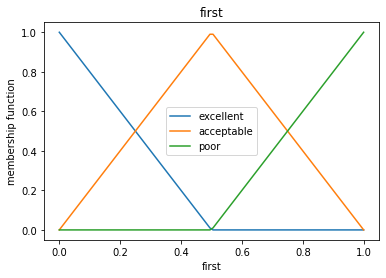

In [6]:
plot_variable(first_cl, (0, 1))

In [7]:

def generate_var_terms(universe: tuple[float], trapezoid_points: tuple[float], n_terms: int = 4) -> list[fl.Term]:
    """Generates terms given universe, trapezoid points and number of term

    Args:
        universe (tuple[float]): general universe of the variable
        trapezoid_points (tuple[float]): left/right 
        n_terms (int, optional): Number of terms. Defaults to 4.

    Returns:
        list[fl.Term]: list of terms
    """
    points = np.linspace(trapezoid_points[0], trapezoid_points[1], n_terms)
    terms = [fl.Trapezoid("first_bin", universe[0] - 1, universe[0], points[0], points[1]),
             fl.Trapezoid("last_bin", points[-2], points[-1], universe[1], universe[1] + 1),]
    
    if len(points) > 2: 
        for i in range(n_terms - 2):
            index = i + 2
            term = fl.Triangle(f'bin_{index}', points[i], points[i + 1], points[i + 2])
            terms.append(term)
    return terms

In [8]:
def _generate_bin_name(index: int, n_bins: int) -> str:
    cat_name = None
    if index == 0:
        cat_name = 'first_bin'
    elif index < n_bins - 1:
        cat_name = f'bin_{index+1}'
    elif index == n_bins - 1:
        cat_name = f'last_bin'
    return cat_name

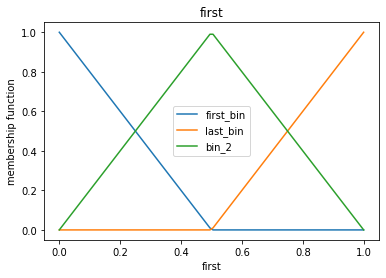

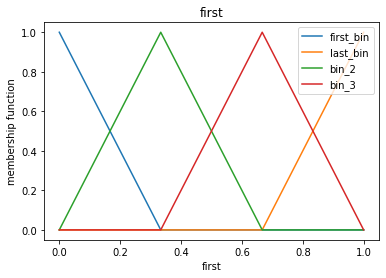

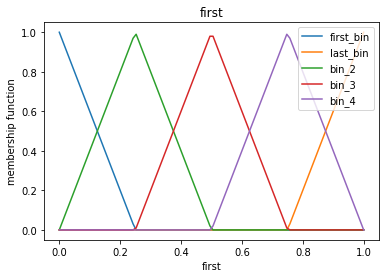

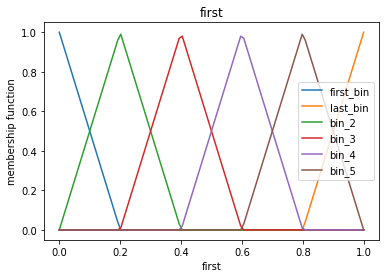

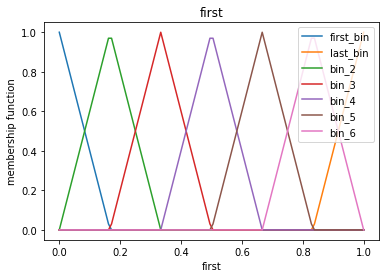

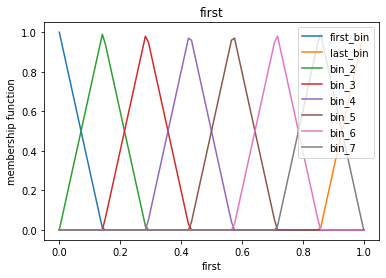

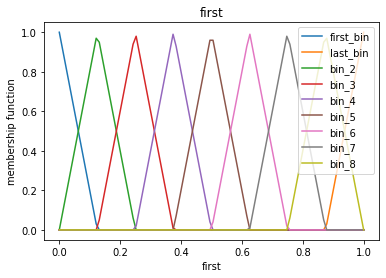

In [9]:
for n_bins in range(3, 10):
    current_cl = fl.InputVariable(
        name="first",
        description="",
        enabled=True,
        minimum=0.0,
        maximum=1.0,
        lock_range=False,
        terms=generate_var_terms(universe=(0, 1), trapezoid_points=(0, 1), n_terms=n_bins))
    plot_variable(current_cl, (0, 1))
    

In [10]:
def calculate_n_priority_bins(n_terms_fitness: int) -> int:
    return 2 * n_terms_fitness - 2 + 1

In [11]:
calculate_n_priority_bins(n_terms_fitness=3)

5

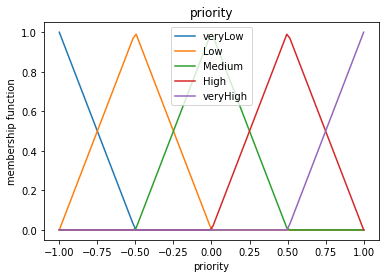

In [12]:
plot_variable(priority_inferencer.priority, universe=(-1, 1))

In [13]:
priority = fl.OutputVariable(
        name="priority",
        description="",
        enabled=True,
        minimum=-1,
        maximum=1,
        lock_range=False,
        defuzzifier=fl.Centroid(),
        aggregation=fl.Maximum(),
        terms=generate_var_terms(universe=(-1, 1), trapezoid_points=(-1, 1), n_terms=calculate_n_priority_bins(3)))

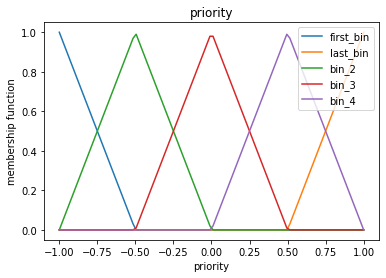

In [14]:
plot_variable(priority, universe=(-1, 1))

In [15]:
def generate_rules(n_terms_fitness: int) -> list[str]:
    """Generates rules for priority inference

    Args:
        n_terms_fitness (int): number of terms of fitness

    Returns:
        list[str]: list of rules for priority inference
    """
    n_bins_priority = calculate_n_priority_bins(n_terms_fitness=n_terms_fitness)
    rules = []
    rules_code = {}
    for first_child_fitness in range(n_terms_fitness -1, -1, -1):
        for second_child_fitness in range(n_terms_fitness -1, -1, -1):
            i, j =  first_child_fitness, second_child_fitness
            if first_child_fitness > second_child_fitness:
                i, j = second_child_fitness, first_child_fitness
            if (i, j) not in rules_code:
                rules_code[(i, j)] = n_bins_priority - (first_child_fitness + second_child_fitness) - 1 
    for i in rules_code:
        rule = f'if first is {_generate_bin_name(i[0], n_terms_fitness)} and second is {_generate_bin_name(i[1], n_terms_fitness)}  then priority is {_generate_bin_name(rules_code[i], n_bins_priority)}'
        rules.append(rule)
    
    return rules[::-1]



In [16]:
"""
Expected rule output for 3 bins:
if first is first_bin and second is first_bin then priority is last_bin
if first is first_bin and second is bin_2 then priority is bin_4
if first is first_bin and second is last_bin then priority is bin_3
if first is bin_2 and second is bin_2 then priority is bin_3
if first is bin_2 and second is last_bin then priority is bin_2
if first is last_bin and second is last_bin then priority is first_bin
"""

'\nExpected rule output for 3 bins:\nif first is first_bin and second is first_bin then priority is last_bin\nif first is first_bin and second is bin_2 then priority is bin_4\nif first is first_bin and second is last_bin then priority is bin_3\nif first is bin_2 and second is bin_2 then priority is bin_3\nif first is bin_2 and second is last_bin then priority is bin_2\nif first is last_bin and second is last_bin then priority is first_bin\n'

In [17]:
generate_rules(n_terms_fitness=3)

['if first is first_bin and second is first_bin  then priority is last_bin',
 'if first is first_bin and second is bin_2  then priority is bin_4',
 'if first is bin_2 and second is bin_2  then priority is bin_3',
 'if first is first_bin and second is last_bin  then priority is bin_3',
 'if first is bin_2 and second is last_bin  then priority is bin_2',
 'if first is last_bin and second is last_bin  then priority is first_bin']

In [18]:
class PriorityInferencer:
    def __init__(self, n_terms_fitness=3) -> None:
        self.n_priority_bins = calculate_n_priority_bins(n_terms_fitness)
        self.first_cl = fl.InputVariable(
            name="first",
            enabled=True,
            minimum=0.0,
            maximum=1.0,
            lock_range=False,
            terms=generate_var_terms(universe=(0, 1), trapezoid_points=(0, 1), n_terms=n_terms_fitness))
        
        self.second_cl = fl.InputVariable(
            name="second",
            enabled=True,
            minimum=0.0,
            maximum=1.0,
            lock_range=False,
            terms=generate_var_terms(universe=(0, 1), trapezoid_points=(0, 1), n_terms=n_terms_fitness))
        
        self.priority = fl.OutputVariable(
            name="priority",
            enabled=True,
            minimum=-1,
            maximum=1,
            lock_range=False,
            defuzzifier=fl.Centroid(),
            aggregation=fl.Maximum(),
            terms=generate_var_terms(universe=(-1, 1), trapezoid_points=(-1, 1), n_terms=self.n_priority_bins))
        
        self.engine = fl.Engine(name="approximation", description="")
        self.engine.input_variables = [self.first_cl, self.second_cl]
        self.engine.output_variables = [self.priority]

        self.engine.rule_blocks = [
            fl.RuleBlock(
            name="",
            description="",
            enabled=True,
            conjunction=fl.Minimum(),
            disjunction=fl.Maximum(),
            implication=fl.Minimum(),
            activation=fl.General(),
            rules= [fl.Rule.create(rule.strip(), self.engine) for rule in generate_rules(n_terms_fitness=n_terms_fitness)])]
    

    def infer_priority(self, first, second):

        if first > second:
            first, second = second, first
        

        self.first_cl.value = first
        self.second_cl.value = second

        self.engine.process()

        return self.priority.value

        


In [19]:
pi = PriorityInferencer(n_terms_fitness=6)
pi.infer_priority(.2, .99)
pi.priority.fuzzy_value()

'0.000/first_bin + 0.000/last_bin + 0.000/bin_2 + 0.000/bin_3 + 0.000/bin_4 + 0.950/bin_5 + 0.050/bin_6 + 0.000/bin_7 + 0.000/bin_8 + 0.000/bin_9 + 0.000/bin_10'

In [20]:
pi.first_cl.fuzzy_value(), priority_inferencer.first_cl.fuzzy_value()

('0.000/first_bin + 0.000/last_bin + 1.000/bin_2 + 0.000/bin_3 + 0.000/bin_4 + 0.000/bin_5',
 'nan/excellent + nan/acceptable + nan/poor')

In [21]:
priority_inferencer.infer_priority(.2, .99)
priority_inferencer.priority.fuzzy_value()

'0.000/veryLow + 0.400/Low + 0.600/Medium + 0.020/High + 0.000/veryHigh'

In [22]:
pi.infer_priority(.2, .99)
pi.priority.fuzzy_value()

'0.000/first_bin + 0.000/last_bin + 0.000/bin_2 + 0.000/bin_3 + 0.000/bin_4 + 0.950/bin_5 + 0.050/bin_6 + 0.000/bin_7 + 0.000/bin_8 + 0.000/bin_9 + 0.000/bin_10'

In [23]:
pi.priority.defuzzify()

In [24]:
pi.priority.fuzzy_value()

'0.000/first_bin + 0.000/last_bin + 0.000/bin_2 + 0.000/bin_3 + 0.000/bin_4 + 0.950/bin_5 + 0.050/bin_6 + 0.000/bin_7 + 0.000/bin_8 + 0.000/bin_9 + 0.000/bin_10'

In [25]:
priority_inferencer.priority.fuzzy_value()

'0.000/veryLow + 0.400/Low + 0.600/Medium + 0.020/High + 0.000/veryHigh'

In [26]:
pi.first_cl.fuzzy_value()

'0.000/first_bin + 0.000/last_bin + 1.000/bin_2 + 0.000/bin_3 + 0.000/bin_4 + 0.000/bin_5'

In [27]:
priority_inferencer.first_cl.fuzzy_value()

'0.600/excellent + 0.400/acceptable + 0.000/poor'

In [28]:
np.random.seed(42)

In [29]:
c1_fitness = np.random.uniform(0, 1, size=100)
c2_fitness = np.random.uniform(0, 1, size=100)

ground_truth = []
result_generalized = []
for i in range(100):
    ground_truth.append(priority_inferencer.infer_priority(c1_fitness[i], c2_fitness[i]))
    result_generalized.append(pi.infer_priority(c1_fitness[i], c2_fitness[i]))

ground_truth = np.array(ground_truth)
result_generalized = np.array(result_generalized)



In [30]:
pi.infer_priority(.21, .2)

0.5857142857142859

In [31]:
priority_inferencer.infer_priority(.21, .2)

0.3439610389610388

In [32]:
(result_generalized ==  ground_truth).all()

False

### Implementation of generalized parameter update mechanism

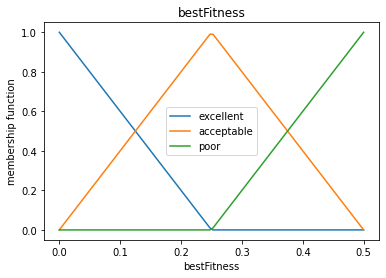

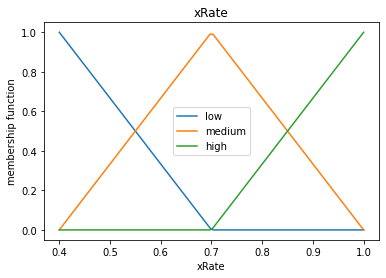

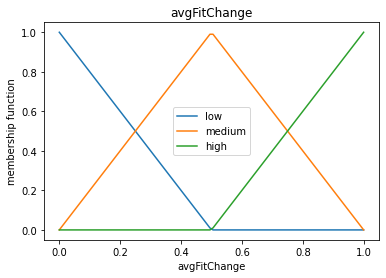

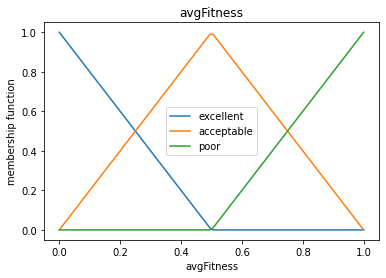

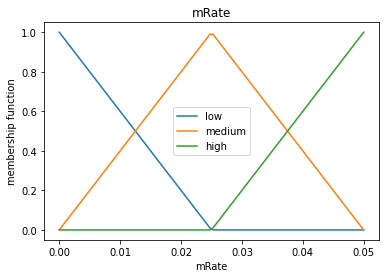

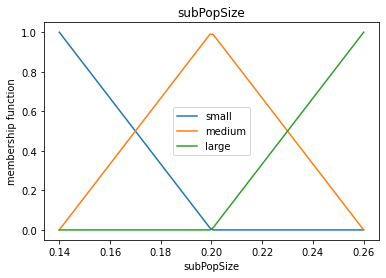

In [33]:
plot_variable(priority_inferencer.best_fitness)
plot_variable(priority_inferencer.x_rate)
plot_variable(priority_inferencer.average_fitness_change)
plot_variable(priority_inferencer.average_fitness)
plot_variable(priority_inferencer.m_rate)
plot_variable(priority_inferencer.subpop_size)

Maybe it's not the best practice, but for this implementation I'll slightly modify avgFitChange both in reference and in generalized model. 

In [34]:
priority_inferencer.average_fitness_change = fl.InputVariable(
        name="avgFitChange",
        description="",
        enabled=True,
        minimum=0.0,
        maximum=1.0,
        lock_range=False,
        terms=[
            fl.Trapezoid("low", -1, 0,  0, 0.5),
            fl.Triangle("medium", 0, 0.5, 1,),
            fl.Triangle("high", 0.5, 1, 1.6),
        ],)

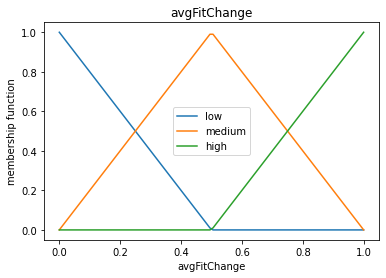

In [35]:
plot_variable(priority_inferencer.average_fitness_change)

In [36]:

rules

NameError: name 'rules' is not defined

In [ ]:
N = 3





In [42]:
def generate_rules_parameter_inference(n_terms: int, params_to_update: list[str] = ['xRate', 'mRate', 'subPopSize']) -> list[str]:
    rules = []

    for param in params_to_update:
        rule = f'if  bestFitness is last_bin  then  {param} is last_bin'
        rules.append(rule)
        rule = f'if  avgFitness is first_bin  then  {param} is first_bin'
        rules.append(rule)
    
    for avg_fit_change in range(n_terms):
        for avg_fitness in range(n_terms - 1, 0, -1):
            if avg_fit_change < np.ceil(n_terms / 2):
                index = avg_fitness
            else:
                index = avg_fitness - 1
            rule_bins = (_generate_bin_name(avg_fit_change, n_bins=n_terms), 
              _generate_bin_name(avg_fitness, n_bins=n_terms),
              _generate_bin_name(index, n_bins=n_terms) )
            
            for param in params_to_update:
                rule = f'if  avgFitChange is {rule_bins[0]}   and  avgFitness is {rule_bins[1]}  then  {param} is {rule_bins[2]}'
                rules.append(rule)
    return rules



In [43]:
generate_rules_parameter_inference(n_terms=3)

['if  bestFitness is last_bin  then  xRate is last_bin',
 'if  avgFitness is first_bin  then  xRate is first_bin',
 'if  bestFitness is last_bin  then  mRate is last_bin',
 'if  avgFitness is first_bin  then  mRate is first_bin',
 'if  bestFitness is last_bin  then  subPopSize is last_bin',
 'if  avgFitness is first_bin  then  subPopSize is first_bin',
 'if  avgFitChange is first_bin   and  avgFitness is last_bin  then  xRate is last_bin',
 'if  avgFitChange is first_bin   and  avgFitness is last_bin  then  mRate is last_bin',
 'if  avgFitChange is first_bin   and  avgFitness is last_bin  then  subPopSize is last_bin',
 'if  avgFitChange is first_bin   and  avgFitness is bin_2  then  xRate is bin_2',
 'if  avgFitChange is first_bin   and  avgFitness is bin_2  then  mRate is bin_2',
 'if  avgFitChange is first_bin   and  avgFitness is bin_2  then  subPopSize is bin_2',
 'if  avgFitChange is bin_2   and  avgFitness is last_bin  then  xRate is last_bin',
 'if  avgFitChange is bin_2   and 

In [44]:
class GeneralizedParamInferencer:
    def __init__(self, n_terms: int = 3) -> None:
        self.n_terms = n_terms

        self.best_fitness = fl.InputVariable(
            name="bestFitness",
            enabled=True,
            minimum=0.0,
            maximum=.5,
            lock_range=False,
            terms=generate_var_terms(universe=(0, .5), trapezoid_points=(0, .5), n_terms=n_terms),)
        
        self.average_fitness = fl.InputVariable(
            name="avgFitness",
            description="",
            enabled=True,
            minimum=0.0,
            maximum=1.0,
            lock_range=False,
            terms=generate_var_terms(universe=(0, 1), trapezoid_points=(0, 1), n_terms=n_terms),)
        
        self.average_fitness_change =  fl.InputVariable(
            name="avgFitChange",
            description="",
            enabled=True,
            minimum=0.0,
            maximum=1.0,
            lock_range=False,
            terms=generate_var_terms(universe=(0, 1), trapezoid_points=(0, 1), n_terms=n_terms),)
        
        self.x_rate = fl.OutputVariable(
            name="xRate",
            enabled=True,
            minimum=0.4,
            maximum=1.0,
            lock_range=False,
            defuzzifier=fl.Centroid(),
            aggregation=fl.Maximum(),
            terms=generate_var_terms(universe=(0.4, 1), trapezoid_points=(0.4, 1), n_terms=n_terms),)
        
        self.m_rate = fl.OutputVariable(
            name="mRate",
            enabled=True,
            minimum=0,
            maximum=.05,
            lock_range=False,
            defuzzifier=fl.Centroid(),
            aggregation=fl.Maximum(),
            terms=generate_var_terms(universe=(0, .05), trapezoid_points=(0, .05), n_terms=n_terms),)
        

        self.subpop_size = fl.OutputVariable(
            name="subPopSize",
            enabled=True,
            minimum=.14,
            maximum=.26,
            lock_range=False,
            defuzzifier=fl.Centroid(),
            aggregation=fl.Maximum(),
            terms=generate_var_terms(universe=(0.14, .26), trapezoid_points=(0, .26), n_terms=n_terms))
        

        self.engine = fl.Engine(name="approximation", description="")
        self.engine.input_variables = [self.average_fitness, self.best_fitness, self.average_fitness_change]
        self.engine.output_variables = [self.x_rate, self.m_rate, self.subpop_size]

        self.engine.rule_blocks = [
            fl.RuleBlock(
        name="",
        description="",
        enabled=True,
        conjunction=fl.Minimum(),
        disjunction=None,
        implication=fl.Minimum(),
        activation=fl.General(),
        rules=[fl.Rule.create(rule.strip(), self.engine) for rule in generate_rules_parameter_inference(n_terms=n_terms)],
        )]

    def infer(self, bestFitness: float, avgFitness: float, avgFitChange: float) -> float:
        self.best_fitness.value = bestFitness
        self.average_fitness.value = avgFitness
        self.average_fitness_change.value = avgFitChange

        self.engine.process()

        return {'xRate':self.x_rate.value, 'mRate':self.m_rate.value, 'subPopSize': self.subpop_size.value}
        

    



In [45]:
gpi = GeneralizedParamInferencer(3)

In [51]:
gpi.infer(.25, .75, .7),

({'xRate': 0.7109413612565444,
  'mRate': 0.025911780104712033,
  'subPopSize': 0.2},)

In [47]:
priority_inferencer =  ParamInference(rule_path_param=Conf.rule_path_param, rule_path_priority=Conf.rule_path_priority)

In [58]:
priority_inferencer.infer(bestFitness=.22, avgFitChange=.75, avgFitness=.7), gpi.infer(bestFitness=.22, avgFitChange=.75, avgFitness=.7)

({'xRate': 0.6890586387434559,
  'mRate': 0.024088219895287973,
  'subPopSize': 0.19781172774869116},
 {'xRate': 0.6890586387434559,
  'mRate': 0.024088219895287973,
  'subPopSize': 0.19669107088063845})

In [70]:
priority_inferencer.engine_params.rule_blocks[0].rules[5].text

'if avgFitChange is medium and avgFitness is acceptable then xRate is medium'

In [65]:
priority_inferencer.best_fitness.fuzzy_value(), priority_inferencer.average_fitness.fuzzy_value(), priority_inferencer.average_fitness_change.fuzzy_value()

('0.000/excellent + 1.000/acceptable + 0.000/poor',
 '0.000/excellent + 0.600/acceptable + 0.400/poor',
 '0.000/low + 0.600/medium + 0.400/high')